#### EDA vs Feature Engineering

Exploratory Data Analysis (EDA) focuses on understanding the structure, distributions, and relationships in the data.  
Feature Engineering, on the other hand, creates new variables that the model will explicitly use for learning patterns.

EDA prepares the data; **Feature Engineering defines the signal the model can learn from**.


## Feature Creation

This section focuses on generating meaningful features from existing variables to better capture temporal effects, weather interactions, and non-linear relationships in bike rental demand.

🔹 **Extract new features from existing ones:**

- hour_category = morning / afternoon / evening / night

- temp_feel_diff = feels_like_temp_norm - temp_norm

🔹 **Aggregate features (if you have hourly → daily data):**

- daily_avg_rentals = hourly_rentals.groupby(date).mean()

🔹 **Create interaction features:**

- temp * humidity

- temp * wind_speed

🔹 **Feature selection**

- Check correlation with target (num_rentals)

- Check feature importance using simple models (Random Forest)

- Drop irrelevant or low-information features

- Remove redundant features (highly correlated with others)

🔹 **Transformations (optional)**

- Log-transform skewed features

- Bin continuous features into categories (e.g., temperature ranges)

- Cyclical encoding for time features (month_sin, month_cos, hour_sin, hour_cos)

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import pearsonr

## Data Loading

Separate datasets are loaded for training, validation, and holdout sets, at both daily and hourly resolutions.  
This strict separation is maintained throughout the pipeline to prevent data leakage and ensure reliable evaluation.


In [2]:
train_day_df = pd.read_csv("D:/VS Code Projects/Datasets/Bike Sharing/data_cleaned/cleaning_train_day.csv")
valid_day_df = pd.read_csv('D:/VS Code Projects/Datasets/Bike Sharing/data_cleaned/cleaning_valid_day.csv')
test_day_df = pd.read_csv('D:/VS Code Projects/Datasets/Bike Sharing/data_cleaned/cleaning_holdout_day.csv')

train_hour_df = pd.read_csv('D:/VS Code Projects/Datasets/Bike Sharing/data_cleaned/cleaning_train_hour.csv')
valid_hour_df = pd.read_csv('D:/VS Code Projects/Datasets/Bike Sharing/data_cleaned/cleaning_valid_hour.csv')
test_hour_df = pd.read_csv('D:/VS Code Projects/Datasets/Bike Sharing/data_cleaned/cleaning_holdout_hour.csv')

## Datetime Handling and Column Cleanup

- Convert the `date` column to datetime format to enable time-based feature extraction.
- Remove auto-generated index columns (`Unnamed: 0`) that do not carry analytical value.


In [3]:
### Ensure datetime & remove the column 'Unnamed: 0'
datasets_list =  [train_day_df,train_hour_df,valid_day_df,valid_hour_df,test_day_df,test_hour_df]
for dataset in datasets_list:
    dataset['date'] = pd.to_datetime(dataset['date'], errors= 'coerce')
    dataset.drop(columns=['Unnamed: 0'], inplace=True, errors='ignore')

print('ISSUE FIXED')
train_hour_df.dtypes

ISSUE FIXED


date                    datetime64[ns]
season                           int64
year                             int64
month                            int64
hour                             int64
holiday                          int64
week_day                         int64
working_day                      int64
weather_situation                int64
temp_norm                      float64
feels_like_temp_norm           float64
humidity_norm                  float64
wind_speed                     float64
casual                           int64
registered                       int64
num_rentals                      int64
dtype: object

In [4]:
dataset.head()

,date,season,year,month,hour,holiday,week_day,working_day,weather_situation,temp_norm,feels_like_temp_norm,humidity_norm,wind_speed,casual,registered,num_rentals
0,2012-10-01,4,1,10,0,0,1,1,1,0.46,0.4545,0.72,0.1045,6,39,45
1,2012-10-01,4,1,10,1,0,1,1,1,0.44,0.4394,0.77,0.0896,5,13,18
2,2012-10-01,4,1,10,2,0,1,1,1,0.46,0.4545,0.72,0.0000,6,6,12
3,2012-10-01,4,1,10,3,0,1,1,1,0.44,0.4394,0.77,0.0000,1,6,7
4,2012-10-01,4,1,10,4,0,1,1,1,0.42,0.4242,0.82,0.1045,0,10,10


## Time-Based Feature Engineering: Hour Categories

To capture daily usage patterns, the continuous `hour` variable is transformed into a categorical feature (`hour_category`) with four intuitive time segments:

- Morning (06–12)
- Afternoon (12–17)
- Evening (17–21)
- Night (21–06)

This allows the model to learn behavioral patterns associated with different times of day.


In [5]:
# Note: The `df.loc[row_condition, column_name] = value` syntax is used to assign values conditionally.


for dataset in datasets_list:
    if 'hour' not in dataset.columns:
        continue

    dataset['hour_category'] = 'night'

    dataset.loc[(dataset['hour'] >= 6) & (dataset['hour'] < 12), 'hour_category'] = 'morning'
    dataset.loc[(dataset['hour'] >= 12) & (dataset['hour'] < 17), 'hour_category'] = 'afternoon'
    dataset.loc[(dataset['hour'] >= 17) & (dataset['hour'] < 21), 'hour_category'] = 'evening'
    dataset.insert(5, 'hour_category', dataset.pop('hour_category'))


In [6]:
dataset.head()

,date,season,year,month,hour,hour_category,holiday,week_day,working_day,weather_situation,temp_norm,feels_like_temp_norm,humidity_norm,wind_speed,casual,registered,num_rentals
0,2012-10-01,4,1,10,0,night,0,1,1,1,0.46,0.4545,0.72,0.1045,6,39,45
1,2012-10-01,4,1,10,1,night,0,1,1,1,0.44,0.4394,0.77,0.0896,5,13,18
2,2012-10-01,4,1,10,2,night,0,1,1,1,0.46,0.4545,0.72,0.0000,6,6,12
3,2012-10-01,4,1,10,3,night,0,1,1,1,0.44,0.4394,0.77,0.0000,1,6,7
4,2012-10-01,4,1,10,4,night,0,1,1,1,0.42,0.4242,0.82,0.1045,0,10,10


## Interaction Feature Engineering

Interaction features are created to capture non-linear effects between weather variables that may jointly influence bike rental demand:

- `temp_x_humidity`: combined thermal discomfort
- `temp_x_wind_speed`: cooling effect due to wind
- `temp_feel_diff`: difference between perceived and actual temperature


#### Note on Normalization

All numeric columns have been normalized beforehand.  
If they weren't, we would need to normalize them because some machine learning algorithms (e.g., SVR) are sensitive to features with large values or extreme ranges, which can disproportionately influence the model.


In [7]:
for dataset in datasets_list:
    dataset['temp_x_humidity'] = dataset['temp_norm'] * dataset['humidity_norm']
    dataset['temp_x_wind_speed'] = dataset['temp_norm'] * dataset['wind_speed']
    dataset['temp_feel_diff'] = dataset['feels_like_temp_norm'] - dataset['temp_norm'] 
    if 'hour' not in dataset.columns:
        dataset.insert(10, 'temp_feel_diff', dataset.pop('temp_feel_diff')) ## Positive temp_feel_diff → feels hotter than actual
        dataset.insert(12, 'temp_x_humidity', dataset.pop('temp_x_humidity'))
        dataset.insert(14, 'temp_x_wind_speed', dataset.pop('temp_x_wind_speed'))
    else:
        dataset.insert(12, 'temp_feel_diff', dataset.pop('temp_feel_diff')) ## Positive temp_feel_diff → feels hotter than actual
        dataset.insert(14, 'temp_x_humidity', dataset.pop('temp_x_humidity'))
        dataset.insert(16, 'temp_x_wind_speed', dataset.pop('temp_x_wind_speed'))
    

In [8]:
dataset.head()

,date,season,year,month,hour,hour_category,holiday,week_day,working_day,weather_situation,temp_norm,feels_like_temp_norm,temp_feel_diff,humidity_norm,temp_x_humidity,wind_speed,temp_x_wind_speed,casual,registered,num_rentals
0,2012-10-01,4,1,10,0,night,0,1,1,1,0.46,0.4545,-0.0055,0.72,0.3312,0.1045,0.048070,6,39,45
1,2012-10-01,4,1,10,1,night,0,1,1,1,0.44,0.4394,-0.0006,0.77,0.3388,0.0896,0.039424,5,13,18
2,2012-10-01,4,1,10,2,night,0,1,1,1,0.46,0.4545,-0.0055,0.72,0.3312,0.0000,0.000000,6,6,12
3,2012-10-01,4,1,10,3,night,0,1,1,1,0.44,0.4394,-0.0006,0.77,0.3388,0.0000,0.000000,1,6,7
4,2012-10-01,4,1,10,4,night,0,1,1,1,0.42,0.4242,0.0042,0.82,0.3444,0.1045,0.043890,0,10,10


## Correlation Analysis (Daily Training Data)

Correlation analysis is performed **only on the training dataset** to explore linear relationships between features and the target variable.

The `year` column is removed because it contains a single unique value and provides no predictive or analytical value.


In [9]:
#drop unused
train_day_df.drop(columns= 'year', inplace= True)
train_hour_df.drop(columns= 'year', inplace= True)

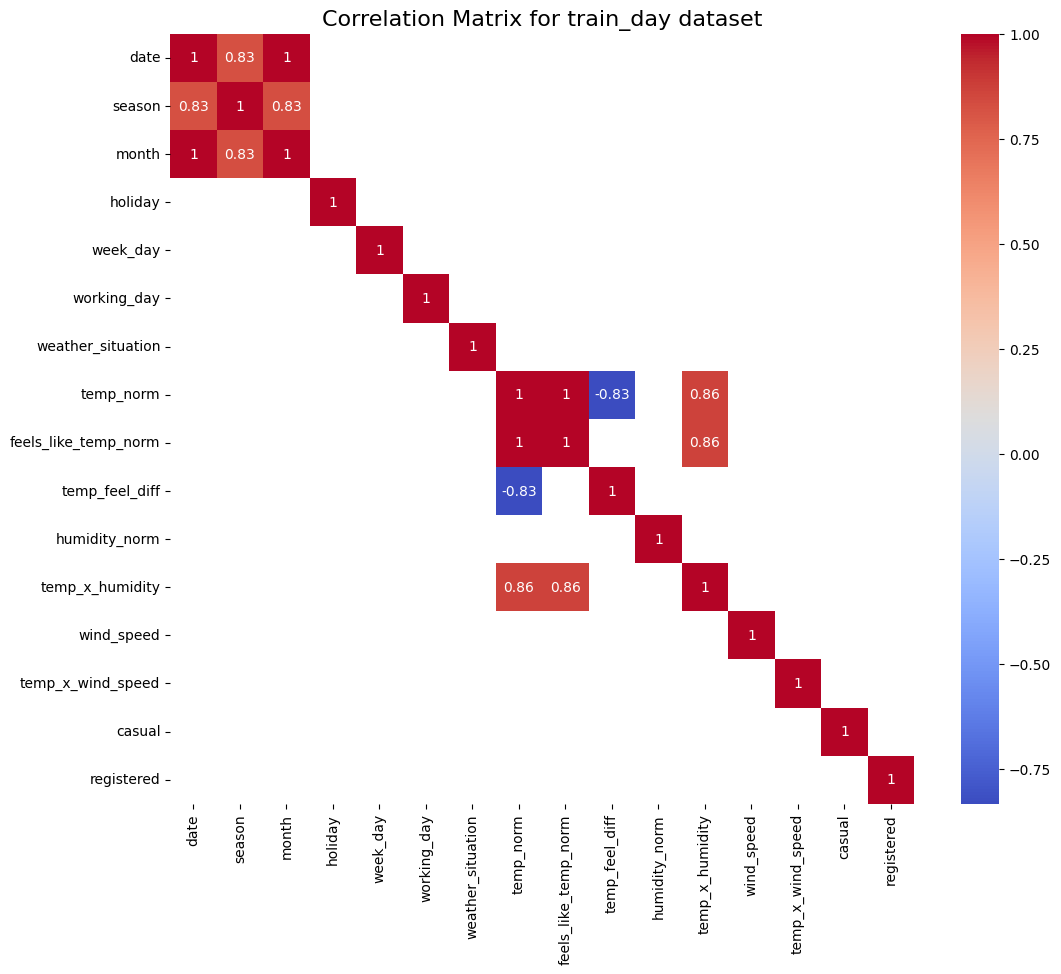

In [10]:
plt.figure(figsize=(12,10))

cols = dataset.columns
corr_df =  train_day_df.drop(columns= 'num_rentals')
corr =corr_df.corr()
mask = np.abs(corr)< 0.8
sns.heatmap(corr, annot=True, cmap='coolwarm', mask= mask)

plt.title("Correlation Matrix for train_day dataset", fontsize=16)
plt.show()




## Key Preprocessing Rules (Avoiding Data Leakage)

- One-hot encode categorical features (e.g., `hour_category`).
- Remove the `year` feature due to lack of variability.
- Fit all encoders and scalers **only on the training set**, then apply the learned transformations to validation and holdout sets.

### Why This Matters

Fitting preprocessing steps on both training and evaluation data would introduce data leakage, allowing future information to influence model learning.  
This results in artificially optimistic evaluation metrics.

By fitting only on training data, evaluation remains a reliable proxy for real-world performance.


## Correlation Analysis (Hourly Training Data)

One-hot encoding is applied **only to the training hourly dataset** to enable correlation analysis involving categorical time features.

At this stage, encoding is used purely for exploratory analysis.  
In the final modeling pipeline, encoders will be fitted on training data and consistently applied to validation and holdout sets.


In [11]:
#one-hot-encoding
train_hour_df = pd.get_dummies(train_hour_df, dtype= int)
train_hour_df.insert(21, 'num_rentals', train_hour_df.pop('num_rentals'))


In [12]:
len(dataset.columns)

20

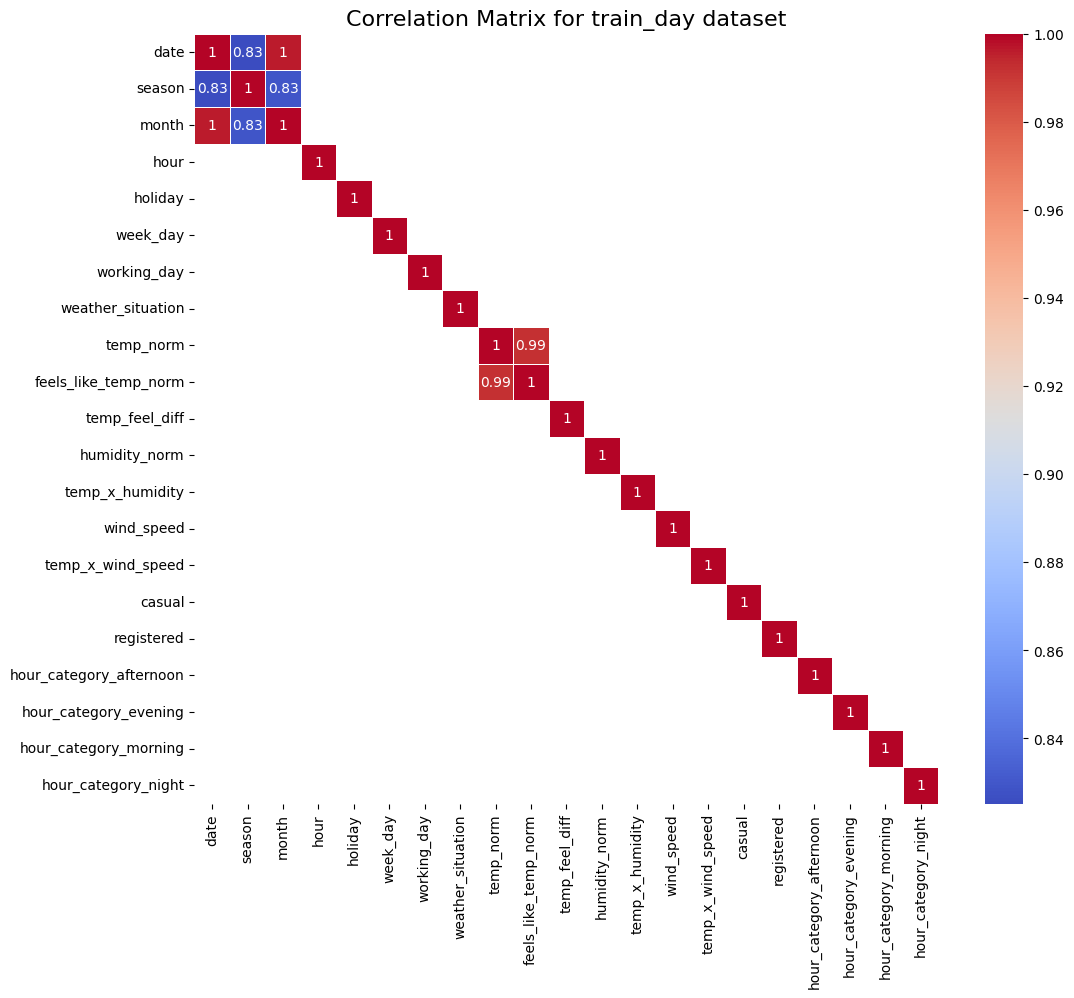

In [13]:
plt.figure(figsize=(12,10))

cols = dataset.columns
corr_df =  train_hour_df.drop(columns= 'num_rentals')
corr =corr_df.corr()
mask = np.abs(corr)< 0.8
sns.heatmap(corr, annot=True, cmap='coolwarm', mask= mask, linewidths= 0.5)

plt.title("Correlation Matrix for train_day dataset", fontsize=16)
plt.show()

## Feature-Target Correlation

Compute Pearson correlation between numeric features and the target (`num_rentals`) for both daily and hourly training datasets.

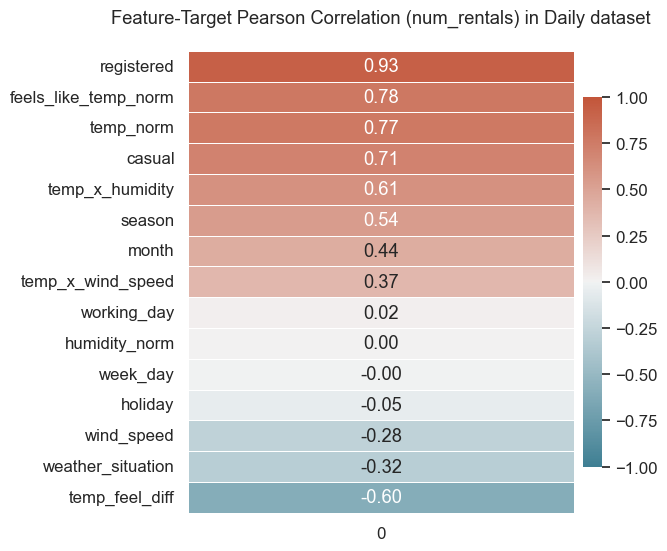

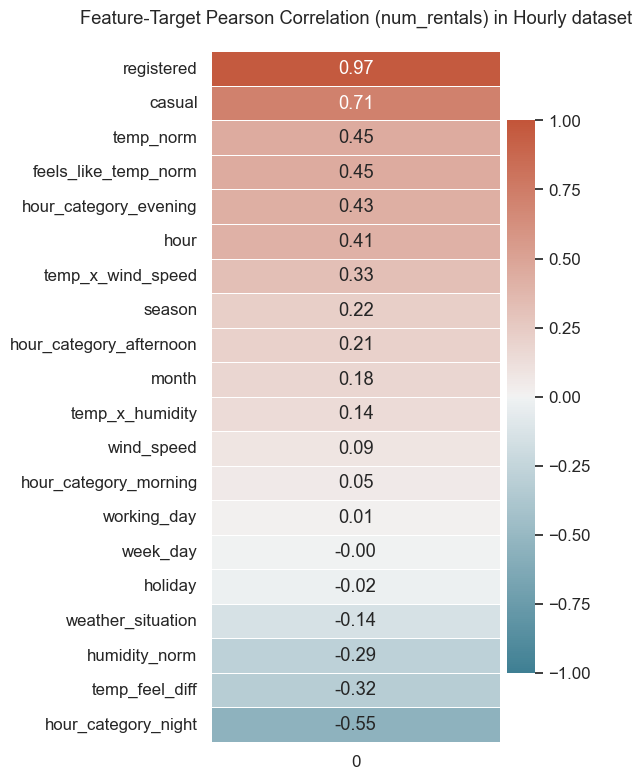

In [14]:
# Compute correlation with target feature for both training datasets
training_sets = [
    ('Daily', train_day_df),
    ('Hourly', train_hour_df)
]


for label, dataset in training_sets:
    target = 'num_rentals'

    # Select numeric columns (exclude target itself)
    num_cols = dataset.select_dtypes(include='number').columns.drop(target, errors='ignore')

    # Compute correlation with target
    corr_vec = dataset[num_cols].corrwith(dataset[target]).sort_values(ascending=False)

    # Plot vertical heatmap for the target variable
    sns.set_theme(style="white")
    sns.set(font_scale=1.1)

    plt.figure(figsize=(6, len(corr_vec)*0.4))  # height proportional to number of features
    ax = sns.heatmap(
        corr_vec.to_frame(),
        annot=True,
        fmt=".2f",
        vmin=-1,
        vmax=1,
        cmap=sns.diverging_palette(220, 20, as_cmap=True),
        center=0,
        linewidths=0.5,
        linecolor="white",
        cbar_kws={"shrink":0.8, "pad":0.02}
    )

    ax.set_title(f"Feature-Target Pearson Correlation (num_rentals) in {label} dataset", pad=20)
    ax.set_ylabel("")
    ax.set_xlabel("")
plt.tight_layout()
plt.show()


In [15]:
numeric_cols = ['weather_situation','wind_speed','temp_x_wind_speed', 'season', 'month']


for col in numeric_cols:
    r, p = pearsonr(train_day_df[col], train_day_df['num_rentals'])
    print(f"{col}: r={r:.3f}, ={p:.2e}")


weather_situation: r=-0.318, =4.90e-10
wind_speed: r=-0.278, =6.67e-08
temp_x_wind_speed: r=0.371, =2.26e-13
season: r=0.542, =3.12e-29
month: r=0.445, =4.06e-19


In [16]:
numeric_cols = ['temp_norm', 'feels_like_temp_norm','hour','season','temp_x_wind_speed','hour_category_evening', 'month','temp_x_humidity', 'weather_situation','humidity_norm','temp_feel_diff']


for col in numeric_cols:
    r, p = pearsonr(train_hour_df[col], train_hour_df['num_rentals'])
    print(f"{col}: r={r:.3f}, ={p:.2e}")


temp_norm: r=0.451, =0.00e+00
feels_like_temp_norm: r=0.447, =0.00e+00
hour: r=0.407, =0.00e+00
season: r=0.222, =9.53e-97
temp_x_wind_speed: r=0.326, =4.48e-213
hour_category_evening: r=0.426, =0.00e+00
month: r=0.179, =2.34e-63
temp_x_humidity: r=0.143, =9.89e-41
weather_situation: r=-0.143, =6.92e-41
humidity_norm: r=-0.289, =1.74e-165
temp_feel_diff: r=-0.325, =2.62e-211


### Feature Selection and Multicollinearity Analysis

#### 1️⃣ Drop Columns with Low Correlation to Target
- Features with **|r| < 0.15** with the target (`num_rentals`) were dropped as they have minimal predictive power.


#### 2️⃣ Moderate Correlation Check
- Features with **|r| between 0.15 and 0.5** were checked using **Pearson correlation**.
- **All features were kept** since all had **p-value < 0.05**, indicating statistically significant correlation with the target.


##### 3️⃣ Multicollinearity Analysis
- Checked retained features for **high correlation between predictors**.

- | Correlation (|r|) > 0.9            | Drop one of the correlated features |
- | Correlation (|r|) 0.8 – 0.9        | Decide based on domain knowledge/context |

**Example:**
- `feels_like_temp_norm` and `temp_x_humidity` → **r = 0.88**
- Drop `temp_x_humidity` because `humidity_norm` is still present and not highly correlated with `feels_like_temp_norm`.

#### 4️⃣ Final Columns to Drop

In [17]:
drop_hour_col = ['wind_speed','hour_category_morning', 'working_day','week_day','holiday','season', 'temp_norm']
drop_daily_col = [ 'working_day','week_day','holiday','humidity_norm','season','temp_norm','temp_x_humidity']


In [18]:
# Daily datasets
train_day_df.drop(columns=drop_daily_col, inplace=True)
valid_day_df.drop(columns=drop_daily_col, inplace=True, errors='ignore')
test_day_df.drop(columns=drop_daily_col, inplace=True, errors='ignore')

# Hourly datasets
train_hour_df.drop(columns=drop_hour_col, inplace=True)
valid_hour_df.drop(columns=drop_hour_col, inplace=True, errors='ignore')
test_hour_df.drop(columns=drop_hour_col, inplace=True, errors='ignore')

### One-Hot Encoding and Column Alignment for Validation and Test Sets

After dropping low-value or redundant columns from validation and test datasets, we need to:

1. **One-hot encode categorical features** in validation and test datasets.  
   - This creates dummy variables for each category present in the dataset.

2. **Align the columns of validation and test sets to the training dataset**.  
   - Ensures that both datasets have exactly the same features as the training set.  
   - Extra columns not present in training (e.g


In [19]:
# Then one-hot encode categorical features
valid_hour_df = pd.get_dummies(valid_hour_df, dtype=int)
test_hour_df  = pd.get_dummies(test_hour_df, dtype=int)

# Align validation and test columns to training set
valid_hour_df = valid_hour_df.reindex(columns=train_hour_df.columns, fill_value=0)
test_hour_df  = test_hour_df.reindex(columns=train_hour_df.columns, fill_value=0)

In [20]:
# ============================
# Save cleaned datasets
# ============================
train_day_df.to_csv("D:/VS Code Projects/Datasets/Bike Sharing/data_processed/feature_engineered_train_day.csv")
valid_day_df.to_csv('D:/VS Code Projects/Datasets/Bike Sharing/data_processed/feature_engineered_valid_day.csv')
test_day_df.to_csv('D:/VS Code Projects/Datasets/Bike Sharing/data_processed/feature_engineered_holdout_day.csv')

train_hour_df.to_csv('D:/VS Code Projects/Datasets/Bike Sharing/data_processed/feature_engineered_train_hour.csv')
valid_hour_df.to_csv('D:/VS Code Projects/Datasets/Bike Sharing/data_processed/feature_engineered_valid_hour.csv')
test_hour_df.to_csv('D:/VS Code Projects/Datasets/Bike Sharing/data_processed/feature_engineered_holdout_hour.csv')